# QuestDB Tutorial for Python

## Getting Started

To get started, you'll need a few things installed and set up. This should be quick. 

1. QuestDB: To install Questdb you can see [Installation](https://questdb.io/getstarted) for complete instructions in case you want to use Docker, or `brew` on MacOS, but the easiest way is to download the binaries and run it directly. Instructions for that are [Here](https://questdb.io/docs/guideBinaries).
2. Jupyter Notebooks: That's what this is. To run it, you should:
    1. install Jupyter Notebooks with `pip3 install --upgrade ipython jupyter`
    2. make sure that the libraries we use in this tutorial are also installed with `pip3 install matplotlib pandas`
    3. clone this repository (`git clone https://github.com/davidgs/QuestNotebook`)
    4. in the repository directory run `jupyter notebook`
   
That will get you right back to a page like this that is interactive, allowing you to run the code and interact with the database yourself.

## Create A Database

We will need someplace to store our data, so let's create a test database where we can put some random data.

We will create a simple table with 5 columns, one of which is a `timestamp` 

The Create operation in QuestDB appends records to bottom of a table. If the table has a designated `timestamp`, new record timestamps must be superior or equal to the latest timestamp. Attempts to add a timestamp in middle of a table will result in a timestamp out of order error.

* `cust_id` is the customer identifier. It uniquely identifies customer.
* `balance_ccy` balance currency. We use `SYMBOL` here to avoid storing text against each record to save space and increase database performance.
* `balance` is the current balance for customer and currency tuple.
* `inactive` is used to flag deleted records.
* `timestamp` timestamp in microseconds of the record. Note that if you receive the timestamp data as a string, it could also be inserted using `to_timestamp`.

This should return a `200` status the first time you run it. If you run it more than once, subsequent runs will return `400` because the database already exists.

In [ ]:
import requests
import urllib.parse as par

r = requests.get("http://localhost:9000/exec?query=create table balances(cust_id int,balance_ccy symbol,balance double,inactive boolean,timestamp timestamp)timestamp(timestamp)")
print(r.status_code)

## Generate some Data

Since we have a new setup, we should add some data to QuestDB so that we can have something to query. We will add some random data, for now. 


In [ ]:
import requests
import random
from datetime import datetime
success = 0
fail = 0
currency = ["$", "€", "£", "¥"]
random.seed()
for x in range(100):
    cust = random.randint(20, 42)
    cur = random.choice(currency)
    bal = round(random.uniform(10.45, 235.15), 2)
    act = bool(random.getrandbits(1))
    query = "insert into balances values(" + str(cust) + ",'" + cur + "'," + str(bal) + "," + str(act) + ",systimestamp())"
    r = requests.get("http://localhost:9000/exec?query=" + query)
    if r.status_code == 200:
        success += 1
    else:
        fail += 1
    
print("Rows inserted: " + str(success))
if fail > 0:
    print("Rows Failed: " + str(fail))
    

## Query Data from QuestDB

Now that we have data available, let's try querying some of it to see what we get back!

In [ ]:
import requests
import io

r = requests.get("http://localhost:9000/exp?query=select * from  balances")
rawData = r.content
print(rawData)


## Read the content into Pandas Dataframe

So that's some ugly data. It's just a massive `csv` string of data. So let's put it into a slightly more useful form using Pandas:

In [ ]:
import pandas as pd

pData = pd.read_csv(io.StringIO(rawData.decode('utf-8')), parse_dates=['timestamp'])
print(pData)


## Narrow the search

That's just getting us *all* the data, but let's narrow the search using some SQL clauses:

In [ ]:
import urllib.parse

q = "select cust_id, balance, balance_ccy, inactive, timestamp from balances where cust_id = 26 and balance_ccy = '$'"
query = urllib.parse.quote(q)
r = requests.get("http://localhost:9000/exp?query=" + query)
queryData = r.content
rawData = pd.read_csv(io.StringIO(queryData.decode('utf-8')), parse_dates=['timestamp'])
print(rawData)

## Plot the data

We will use `matplotlib` to plot the data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x122649d90>],
      dtype=object)

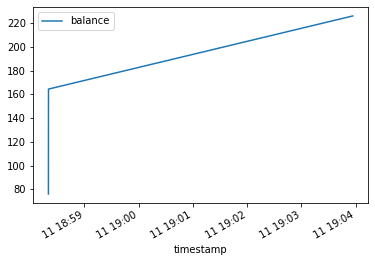

In [22]:
from matplotlib import pyplot as plt

rawData.plot("timestamp", ["balance"], subplots=True)

